In [1]:
# Updated Transfer Learning 
# Sprint 1, November 10

In [2]:
#### PACKAGE IMPORTS ####

# Run this cell first to import all required packages. Do not make any imports elsewhere in the notebook
from numpy.random import seed
seed(8)
import cv2
import imageio
import pandas as pd
import tensorflow as tf
from collections import Counter  # Import Counter class
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import datasets, model_selection
from sklearn.metrics import confusion_matrix
%matplotlib inline

from keras.applications import ResNet50
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.utils import compute_class_weight
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from keras import Input, layers
from keras.models import  load_model
from keras.layers import RandomFlip, RandomRotation, RandomBrightness, RandomContrast, Flatten, Dense, LeakyReLU, Dropout, Softmax, Conv2D, MaxPooling2D
from keras.layers import Dropout, BatchNormalization
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from imblearn.over_sampling import RandomOverSampler

In [3]:
import imghdr

In [4]:
from sklearn.utils import compute_class_weight

In [5]:
data_dir = 'Classifications'

In [6]:
os.listdir(os.path.join(data_dir, 'Darks'))

['018b72bf1ef4f3a184c0029ffcff3dde17f4a883ef472f801625002b36002f98.jpg',
 '02779527d52d42a0d353d3c7cbac61264693be565d5b97b643bbd9c105aa3d56.cr2',
 '01cfd9f7469ffcfa0ba6944a196e51d9a82206a6508de3dcac7184833390b0a8.jpg',
 '01fd8bdc93dd51ab2088756ada1ee3558e6f27e4493a7a64e164c5aae5df66c4.jpg',
 '026dce0094f4e27e6810f5942a3d205e396f15a02499aac1a71588f68e091c71.jpg',
 '01652a61bb2dcc2fccf21acc2ad100b235559a958ed0384e6eab06eaa5587d1a.nef',
 '00101bc23c829bc6247f0e0ee97851573e0521f1af294d04e6cd93a9441be01f.jpg',
 '0108312b1cb01034c6476c8d2a309eb68cd72ac520dd1b40a87147ce4c6019b2.jpg',
 '0214a32fabdf9e585757789768aaa79942388f829c18abbeda56acc16dc0129f.cr2',
 '005610412b35d526ef59895fa84b6f5e110ccfce7a5ce6f9df2bcc6a80e62bd0.cr2',
 '000cbc97845b0b30093c94507163ec18f82ea1e178ad57302a22859451130a80.jpg',
 '005a87231314e35fec9267907797ec1199c3c62efe166c99130daa7fc339e0b1.jpg',
 '017885c331beefb013738c1da85bb371cb3de813cd5a1ca7269ca80d3c9cf3ac.nef',
 '000cbc97845b0b30093c94507163ec18f82ea1e178ad57302

In [7]:
img_exts = ['jpeg', 'jpg', 'bmp', 'png', 'nef', 'cr2'] # figure out why all the images are not being loaded in

In [8]:
img = plt.imread(os.path.join(data_dir, 'Darks', 'eeb459aefed3c784b8bdfe6960802d4a70ca581e58d2d5a3f29653fade418a98.jpg'))

In [9]:
img.shape

(4928, 7380, 3)

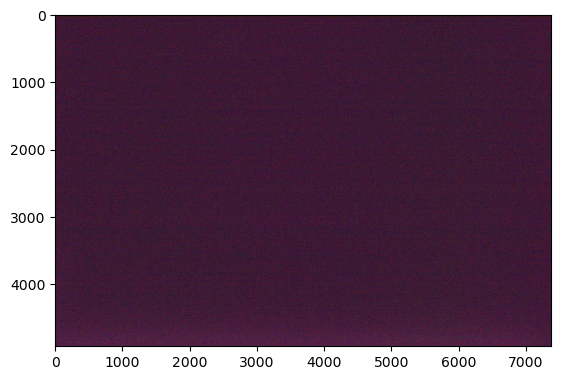

In [10]:
plt.imshow(img)

In [40]:
from PIL import Image
from sklearn.model_selection import train_test_split

# Dataset Parameters - DO NOT CHANGE
BATCH_SIZE = 32
IMG_SIZE = (256, 256, 3)
AUTOTUNE = tf.data.AUTOTUNE

# Define functions for data loading and preprocessing
def load_data(data_dir):
  """Loads image data from the specified directory.

  Args:
    data_dir: String path to the directory containing images and labels.

  Returns:
    A pandas DataFrame with columns 'image_id', 'label', 'label_index', 'set', and 'path'.
  """
  image_id = []
  label = []
  label_index = []
  set_list = []

  # Iterate over subfolders in data_dir
  for label_idx, label_folder in enumerate(os.listdir(data_dir)):
    subfolder = os.path.join(data_dir, label_folder)
    if os.path.isdir(subfolder):
      # Iterate over images in the subfolder
      for img_file in os.listdir(subfolder):
        if img_file.endswith('.jpg') or img_file.endswith('.jpeg') or img_file.endswith('.bmp') or img_file.endswith('.png') or img_file.endswith('.nef') or img_file.endswith('.cr2'):
          # Append image details to respective lists
          image_id.append(img_file)
          label.append(label_folder)
          label_index.append(label_idx)
          set_list.append('train')

  # Create DataFrame and add a file path column
  df = pd.DataFrame({'image_id': image_id, 'label': label, 'label_index': label_index, 'set': set_list})
  df.loc[:, 'path'] = df.apply(lambda row: os.path.join(data_dir, row['label'], row['image_id']), axis=1)

  return df

def preprocess_image(image_path):
  """Preprocesses an image by resizing and normalizing it.

  Args:
    image_path: String path to the image file.

  Returns:
    A NumPy array of the preprocessed image, with shape (256, 256, 3).
  """
  image = Image.open(image_path)
  resized_image = image.resize((256, 256))

  # Ensure 3 channels (RGB) for consistency
  if resized_image.mode != 'RGB':
    resized_image = resized_image.convert('RGB')

  array_image = np.array(resized_image)
  normalized_image = array_image / 255.0
  return normalized_image

# Load and preprocess data
data_dir = "Classifications"  # Replace with your data directory path
df = load_data(data_dir)

# Separate features and target variable
X = df.drop('label', axis=1)
y = df['label']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess images
X_train_processed = np.array([preprocess_image(image_path) for image_path in X_train['path']])
X_test_processed = np.array([preprocess_image(image_path) for image_path in X_test['path']])

# Reshape data to match model input
X_train_processed = X_train_processed.reshape(-1, *IMG_SIZE)  # Using unpacking for clarity
X_test_processed = X_test_processed.reshape(-1, *IMG_SIZE)

# Convert labels to integer indices
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Create TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_processed, y_train_encoded))\
             .batch(BATCH_SIZE) # Ensure BATCH_SIZE is defined
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_processed, y_test_encoded))\
             .batch(BATCH_SIZE)


In [41]:
for image_path in df['path'].to_numpy():
    print(image_path)
    

Classifications/0to25percentPartialEclipse/00b6f1ac5d8d874cc5e2f98a93530aef3082f12965d43778f0bc8eb11e6464fc.cr2
Classifications/0to25percentPartialEclipse/0077e5c0a9d951b7a4723b56298808e4417f7600d5dcd2cb3ab499ff6c952ed5.jpg
Classifications/0to25percentPartialEclipse/00d2ccc4963c0f8ffb3f1c2f286b691a62043d8e01d07ce4706f27656e6e716b.jpg
Classifications/0to25percentPartialEclipse/6ac01773da0e961feb1e035ad47e44bccc0158356107ad67e400f07411a2e7a8.jpg
Classifications/0to25percentPartialEclipse/05e7d3f0f022176165169b4c169934c5abb2f315a0415e06c0c1c06a073e1010.cr2
Classifications/0to25percentPartialEclipse/408580dfe9cd5d872485ea70eb598a4738fc287bd1736e8aebe6e8d2944bf83e.jpg
Classifications/0to25percentPartialEclipse/0159abec3cb809cff0717fc624c0d794e4eac8268bebfe934d027f0f7a822e85.jpg
Classifications/0to25percentPartialEclipse/5e42f642e5c2b8273eb4fffa8495a781f7b9fff539cefcd6eadeee9bda82e6db.jpg
Classifications/0to25percentPartialEclipse/0247efd4a57e854d9a9c8c311f00ab86396a1e6270225f0b980ccfaf417ec

In [42]:
print(y.value_counts())

label
TotalSolarEclipse                        340
Darks                                    131
56to95percentPartialEclipse               98
0to25percentPartialEclipse                90
DiamondRing_BaileysBeads_SolarEclipse     79
26to55percentPartialEclipse               65
NotASolarEclipse                          55
Flats                                     36
Name: count, dtype: int64


In [43]:
print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))
print("Train dataset unique class labels:", 
np.unique(y_train_encoded, return_counts=True)[1])
print("Test dataset unique class labels:", 
np.unique(y_test_encoded, return_counts=True)[1])

Train dataset size: 23
Test dataset size: 6
Train dataset unique class labels: [ 67  56  79 101  61  31  41 279]
Test dataset unique class labels: [23  9 19 30 18  5 14 61]


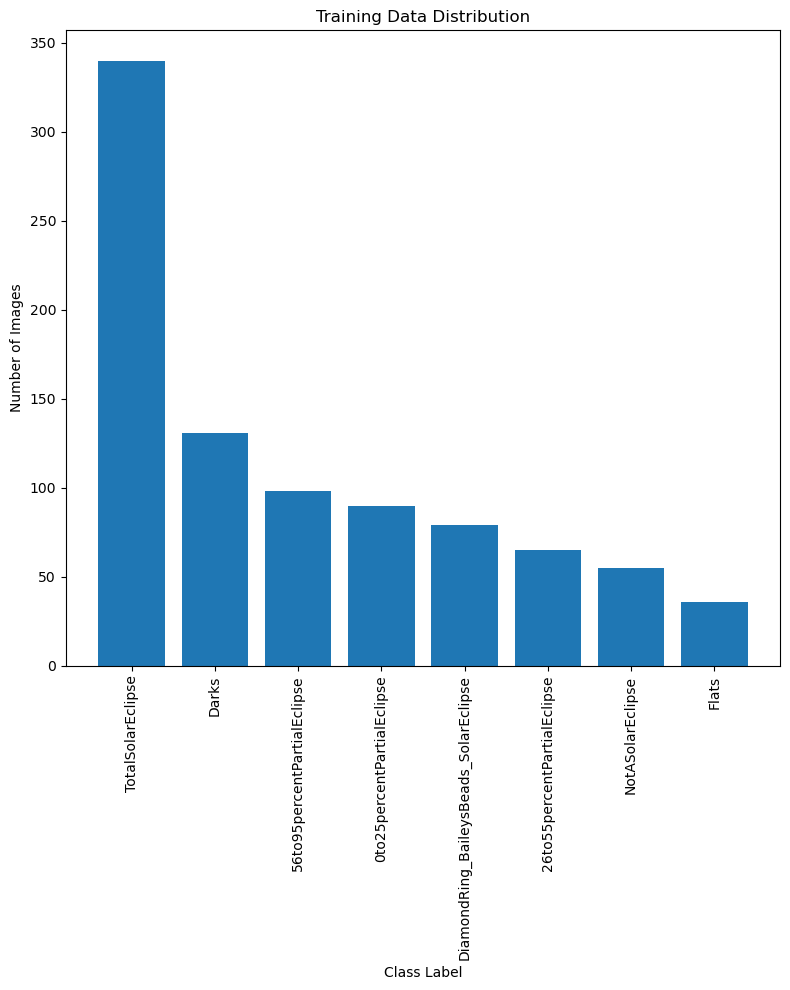

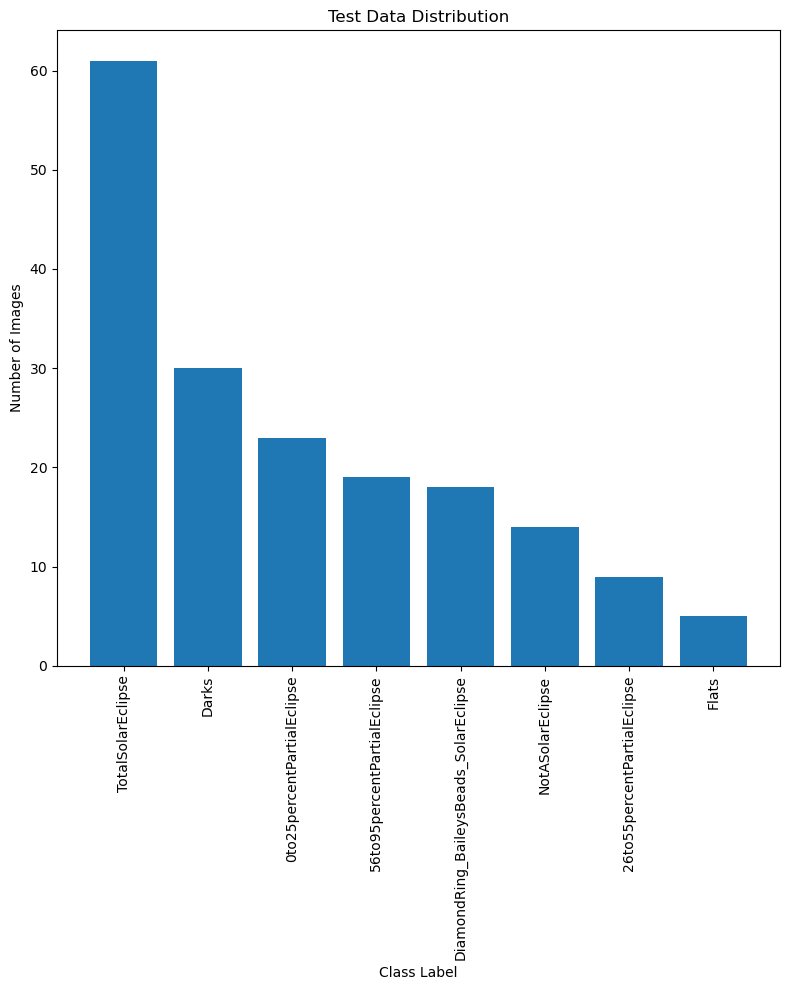

In [44]:
# Filter training data
df_train = df[df['set'] == 'train']  # Assuming 'train' is the training set label

# Count images per class in training data
class_counts = df_train['label'].value_counts().sort_values(ascending=False)

# Set a larger figure size for taller graphs (adjust as needed)
plt.figure(figsize=(8, 10))  # Adjust width and height for desired size

# Plot bar graph for class distribution (training data)
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Training Data Distribution')

# Rotate y-axis labels for better readability (if many categories)
plt.xticks(rotation=90)  # Adjust for x-axis labels if needed
plt.tight_layout()  # Adjust layout to accommodate rotated labels

plt.show()

# Count images per class in test data (after encoding labels for consistency)
test_df = pd.DataFrame({'label': y_test})
test_class_counts = test_df['label'].value_counts().sort_values(ascending=False)

# Set a larger figure size for taller graphs (adjust as needed)
plt.figure(figsize=(8, 10))  # Adjust width and height for desired size

# Plot bar graph for class distribution (test data)
plt.bar(test_class_counts.index, test_class_counts.values)
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Test Data Distribution')

# Rotate y-axis labels for better readability (if many categories)
plt.xticks(rotation=90)  # Adjust for x-axis labels if needed
plt.tight_layout()  # Adjust layout to accommodate rotated labels
plt.show()

In [45]:
y_train_encoded

array([4, 5, 4, 7, 3, 1, 7, 4, 0, 0, 3, 7, 2, 7, 0, 6, 7, 7, 3, 3, 7, 4,
       5, 7, 5, 3, 7, 7, 7, 7, 7, 4, 4, 7, 7, 7, 0, 7, 2, 7, 7, 1, 2, 7,
       6, 3, 2, 7, 6, 4, 0, 7, 7, 6, 4, 2, 7, 3, 3, 4, 7, 6, 7, 7, 7, 7,
       4, 7, 7, 2, 7, 0, 1, 7, 0, 7, 5, 3, 3, 6, 1, 7, 7, 4, 7, 7, 7, 7,
       7, 7, 7, 2, 7, 4, 4, 3, 1, 3, 2, 7, 3, 0, 1, 4, 7, 1, 2, 0, 7, 2,
       3, 5, 7, 4, 1, 2, 0, 7, 7, 0, 7, 4, 3, 1, 2, 2, 4, 3, 1, 7, 3, 2,
       0, 7, 1, 7, 0, 7, 7, 7, 0, 4, 7, 3, 0, 7, 3, 7, 6, 7, 3, 7, 4, 0,
       7, 5, 0, 0, 6, 6, 7, 7, 0, 2, 7, 5, 2, 7, 7, 7, 3, 7, 7, 2, 7, 7,
       2, 2, 7, 3, 0, 1, 7, 7, 1, 1, 4, 1, 3, 0, 4, 3, 3, 3, 7, 7, 1, 0,
       7, 0, 0, 4, 2, 3, 7, 7, 7, 2, 7, 3, 7, 2, 7, 7, 7, 4, 6, 7, 4, 7,
       0, 0, 7, 6, 7, 3, 7, 7, 2, 7, 7, 7, 4, 7, 0, 2, 0, 4, 2, 7, 3, 3,
       7, 4, 5, 3, 2, 2, 1, 7, 7, 3, 6, 2, 7, 7, 7, 1, 0, 7, 7, 6, 0, 7,
       2, 6, 7, 7, 2, 0, 5, 1, 1, 5, 6, 2, 0, 3, 7, 3, 7, 7, 1, 6, 7, 1,
       2, 7, 7, 7, 7, 6, 4, 7, 1, 7, 7, 3, 7, 4, 6,

In [46]:
y_test_encoded

array([7, 7, 7, 7, 0, 6, 6, 4, 2, 1, 1, 7, 7, 2, 4, 3, 7, 7, 3, 1, 6, 7,
       2, 7, 7, 7, 0, 7, 0, 7, 7, 1, 3, 2, 2, 7, 0, 2, 3, 5, 1, 7, 7, 5,
       4, 0, 0, 4, 2, 3, 7, 3, 4, 3, 6, 7, 0, 6, 2, 0, 7, 7, 7, 2, 2, 3,
       0, 7, 7, 7, 4, 4, 7, 3, 3, 7, 3, 5, 4, 6, 6, 0, 4, 7, 2, 7, 2, 4,
       3, 2, 2, 7, 7, 7, 0, 6, 7, 4, 4, 4, 3, 7, 6, 3, 7, 7, 7, 7, 6, 2,
       3, 2, 7, 7, 7, 3, 1, 6, 4, 3, 7, 2, 6, 0, 3, 7, 5, 1, 3, 3, 4, 0,
       7, 3, 3, 3, 6, 2, 7, 0, 3, 3, 4, 7, 3, 7, 2, 0, 0, 7, 7, 7, 5, 1,
       0, 7, 7, 0, 7, 7, 6, 3, 7, 4, 0, 0, 7, 3, 7, 4, 1, 7, 7, 3, 7, 3,
       0, 0, 0])

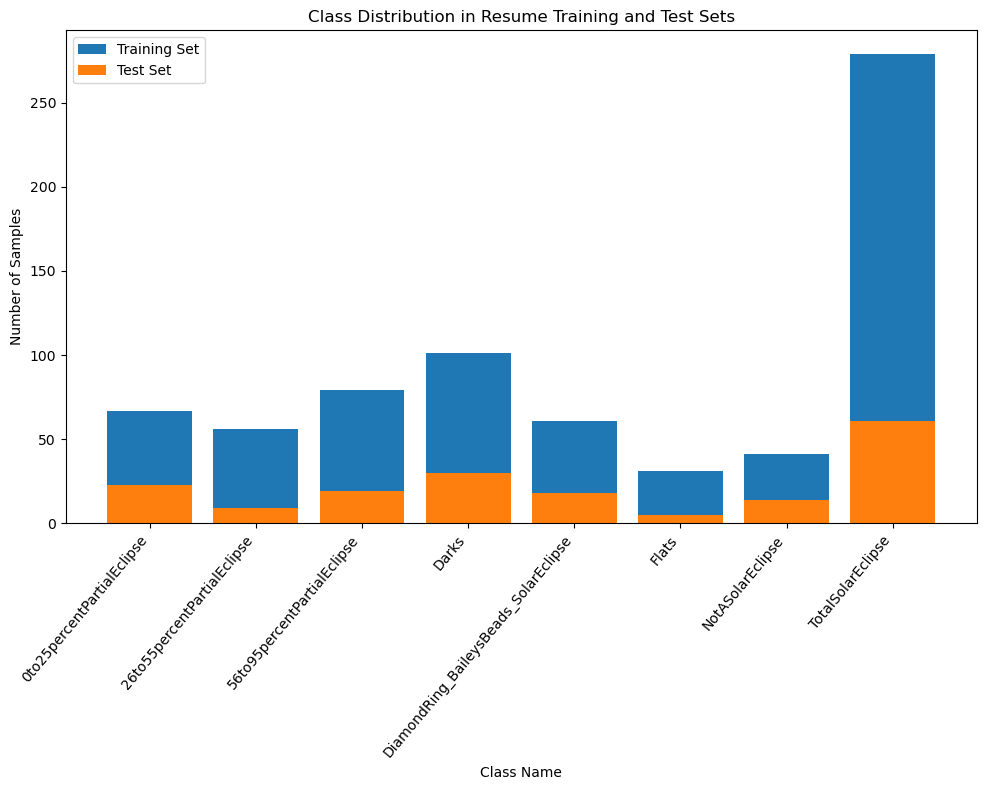

In [68]:
# Get class distribution for training data
train_class_distribution = dict(Counter(y_train_encoded))
sorted_train_class_distribution = dict(sorted(train_class_distribution.items()))

# Get class distribution for test data
test_class_distribution = dict(Counter(y_test_encoded))
sorted_test_class_distribution = dict(sorted(test_class_distribution.items()))

# Get class names (folder names) from the label encoder
class_names = label_encoder.classes_

# Create a bar chart
plt.figure(figsize=(10, 8))
plt.bar(class_names, sorted_train_class_distribution.values(), label='Training Set')
plt.bar(class_names, sorted_test_class_distribution.values(), label='Test Set')
plt.xlabel("Class Name")  # Update label
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Resume Training and Test Sets")
plt.xticks(rotation=50, ha='right')  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()
plt.show()

In [66]:
# Sort train_class_distribution by key in ascending order
sorted_train_class_distribution = dict(sorted(train_class_distribution.items()))

# Print the sorted dictionary
print(sorted_train_class_distribution)


{0: 67, 1: 56, 2: 79, 3: 101, 4: 61, 5: 31, 6: 41, 7: 279}


In [60]:
test_class_distribution.values()

dict_values([61, 23, 14, 18, 19, 9, 30, 5])

In [61]:
train_class_distribution.values()

dict_values([61, 31, 279, 101, 56, 67, 79, 41])

In [62]:
train_class_distribution

{4: 61, 5: 31, 7: 279, 3: 101, 1: 56, 0: 67, 2: 79, 6: 41}

In [63]:
test_class_distribution

{7: 61, 0: 23, 6: 14, 4: 18, 2: 19, 1: 9, 3: 30, 5: 5}

In [ ]:
rand_seed = 0

# Create a TF sequential model for data augmentation
data_augmentation = tf.keras.Sequential([
  RandomFlip('horizontal', seed=rand_seed),
  RandomRotation(0.2, seed=rand_seed),
  RandomBrightness(0.2, seed=rand_seed),
  RandomContrast(0.2, seed=rand_seed),
])


In [ ]:
# Oversample Training Data (using RandomOverSampler from imblearn)
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Print the unique class labels and counts after oversampling
print("Unique class labels and counts after oversampling:")
print(np.unique(y_train_resampled, return_counts=True))

# Preprocess oversampled images
X_train_resampled_processed = np.array([preprocess_image(image_path) for image_path in X_train_resampled['path']])
X_train_resampled_processed = X_train_resampled_processed.reshape(-1, *IMG_SIZE)

# Convert labels to integer indices after oversampling
label_encoder = LabelEncoder()
y_train_encoded_resampled = label_encoder.fit_transform(y_train_resampled)

# Create TensorFlow Datasets (using oversampled data)
train_dataset_resampled = tf.data.Dataset.from_tensor_slices((X_train_resampled_processed, y_train_encoded_resampled)) \
  .shuffle(len(X_train_resampled_processed)).batch(BATCH_SIZE)  # Corrected indentation

print("Train dataset size after oversampling:", len(train_dataset_resampled))


In [ ]:
print(tf.__version__)

In [ ]:
# update class weights
def compile_model(model):
    """
    This function takes in the model returned from your get_model function, and compiles it with an optimiser,
    loss function and metric.
    Compile the model using the Adam optimiser (with learning rate set to 0.0001), 
    the categorical crossentropy loss function, and accuracy as the only metric. 
    Your function doesn't need to return anything; the model will be compiled in-place.
    """
    
    # YOUR CODE HERE
    # Compile the model 
    model2.compile(optimizer=Adam(learning_rate=0.00001),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               metrics=['accuracy'])



    return model

In [ ]:

# Compile model
# compile_model(model1)

# Define a callback to reduce the learning rate based on the validation accuracy
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            mode = 'min',
                                            factor=0.5,
                                            min_lr=0.00001)

# Define a callback for checkpointing
checkpoint = ModelCheckpoint(filepath='checkpoints_best_only/checkpoint.weights.h5',
                            save_freq='epoch',
                            monitor='val_accuracy',
                            save_weights_only=True,
                            mode='max',
                            save_best_only=True,
                            verbose=0)


# Define a callback for early stopping
EarlyStopping = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)


In [ ]:
from keras.optimizers import Adam
from keras import regularizers
from tensorflow.keras.applications import InceptionV3

In [ ]:
# Load the pre-trained InceptionV3 model without the top layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


# Load the RESNET50 model without the top layer
#base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3), pooling='avg')

# Freeze the layers in the base model
#for layer in base_model.layers[:50]:
    #layer.trainable = False

# Freeze the layers in the base model
for layer in base_model.layers[:170]:  # Freeze most InceptionV3 layers (adjust as needed)
  layer.trainable = False

model2 = Sequential()
#model2.add(data_augmentation)
model2.add(base_model)
# Add Flatten layer to collapse spatial dimensions
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.8))
model2.add(Dense(8, activation='softmax'))

compile_model(model2)

model2.summary()


In [ ]:
initial_epochs = 50
# Train the model using the oversampled train dataset
class_weights = {
    0: 1 / (41 / len(X_train)),
    1: 1 / (41 / len(X_train)),
    2: 1 / (41 / len(X_train)),
    3: 1 / (41 / len(X_train)),
    4: 1 / (41 / len(X_train)),
    5: 1 / (41 / len(X_train)),
    6: 1 / (41 / len(X_train)),
    7: 1 / (41 / len(X_train)),
}

history_resampled = model2.fit(
    train_dataset_resampled,
    epochs=initial_epochs,
    validation_data=test_dataset,
    callbacks=[lr_reduction, EarlyStopping],
    class_weight=class_weights
)


In [ ]:
# Print a summary of the training accuracy and loss
acc = [0.] + history_resampled.history['accuracy']
val_acc = [0.] + history_resampled.history['val_accuracy']
loss = history_resampled.history['loss']
val_loss = history_resampled.history['val_loss']

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
"""plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')"""
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0,1.0])
"""plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')"""
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.xlabel('epoch')

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve

# Make predictions on the test dataset
y_pred = model2.predict(X_test_processed)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate class-wise accuracy
class_accuracies = {}
for i in range(len(label_encoder.classes_)):
  y_true = (y_test_encoded == i)  # Assuming one-hot encoded test labels
  y_pred_class = y_pred_classes == i
  class_accuracy = accuracy_score(y_true, y_pred_class)
  class_accuracies[label_encoder.classes_[i]] = class_accuracy

# Print class-wise accuracies
print("Accuracy per Class:")
for class_name, accuracy in class_accuracies.items():
  print(f"{class_name}: {accuracy:.4f}")

# Evaluate the model on the test dataset
y_pred = model2.predict(X_test_processed)
y_pred_classes = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test_encoded, y_pred_classes)
confusion = confusion_matrix(y_test_encoded, y_pred_classes)

# Normalize confusion matrix
confusion_norm = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]

#print("Normalized Confusion Matrix:")
#print(confusion_norm)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion_norm)

# Plot the confusion matrix
plt.imshow(confusion_norm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_, rotation=90)
plt.yticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_)
plt.colorbar()

import matplotlib.pyplot as plt

def show_misclassified_images(misclassified_images, predicted_labels, true_labels, title):
  """Displays misclassified images in a grid, each image occupying a full row."""
  num_images = len(misclassified_images)
  rows, cols = num_images, 1  # One image per row

  fig, axes = plt.subplots(rows, cols, figsize=(12, num_images * 5))  # Adjust figsize for image size

  for i in range(num_images):
      image_path = misclassified_images.iloc[i]
      image = plt.imread(image_path)

      # Ensure consistent image size (optional resizing)
      image_height, image_width, _ = image.shape
      max_dim = 500  # Adjust max dimension for desired image size
      scale = max(max_dim / image_height, max_dim / image_width)
      resized_image = cv2.resize(image.astype(np.float32), None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC) if scale > 1 else image

      axes[i].imshow(resized_image)
      axes[i].set_title(f"Predicted: {predicted_labels[i]} Truth: {true_labels.iloc[i]}")
      axes[i].axis('off')

  fig.suptitle(title, fontsize=16)  # Add title for the entire figure
  plt.tight_layout()
  plt.show()

misclassified_indices = []
for i in range(len(label_encoder.classes_)):
  y_true = (y_test_encoded == i)
  y_pred_class = y_pred_classes == i
  accuracy = accuracy_score(y_true, y_pred_class)
  # Check for misclassified instances
  misclassified_count = len(y_true) - np.sum(y_true == y_pred_class)
  if misclassified_count > 0:
    # Get indices of misclassified instances for this class
    misclassified_indices.extend(np.where(y_true != y_pred_class)[0])

misclassified_images = X_test.iloc[misclassified_indices]["path"]
predicted_labels = label_encoder.classes_[y_pred_classes[misclassified_indices]]
true_labels = y_test.iloc[misclassified_indices]

show_misclassified_images(misclassified_images, predicted_labels, true_labels, "Misclassified Images (One Image Per Row)")

for i in range(num_images_to_show):
    image_path = misclassified_images.iloc[i]
    image = plt.imread(image_path)
    axes[i].imshow(image)
    axes[i].set_title(f"Predicted: {label_encoder.classes_[y_pred_classes[misclassified_indices[i]]]} Truth: {y_test.iloc[misclassified_indices[i]]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Generate ROC curves
plt.figure(figsize=(8, 6))
for i in range(len(label_encoder.classes_)):
    y_true = (y_test_encoded == i)
    y_prob = y_pred[:, i]
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    plt.plot(fpr, tpr, label=f'{label_encoder.classes_[i]} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')

# Generate Precision-Recall curves
plt.figure(figsize=(8, 6))
for i in range(len(label_encoder.classes_)):
    y_true = (y_test_encoded == i)
    y_prob = y_pred[:, i]
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    plt.plot(recall, precision, label=f'{label_encoder.classes_[i]}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')

plt.show()

# normalize hists for confusion matrix

In [ ]:
correctly_classified_indices = []
for i in range(len(y_pred_classes)):
  # Compare elements at the same index using equality comparison
  if y_pred_classes[i] == y_test_encoded[i]:
    correctly_classified_indices.append(i)

num_images_to_show = min(5, len(correctly_classified_indices))

# Assuming 'path' is a column in your DataFrame X_test
for i in range(num_images_to_show):
  image_path = X_test.iloc[correctly_classified_indices[i]]["path"]
  image = plt.imread(image_path)

  # Display the image with title (optional)
  plt.imshow(image)
  predicted_label = label_encoder.classes_[y_pred_classes[correctly_classified_indices[i]]]  # Assuming you have a label encoder
  actual_label = y_test.iloc[correctly_classified_indices[i]]
  plt.title(f"Predicted: {predicted_label} Truth: {actual_label}")
  plt.axis('off')  # Hide axes for better visualization (optional)
  plt.show()




In [ ]:
# Create a new model that outputs intermediate feature maps
intermediate_layer_model = tf.keras.Model(inputs=model1.input, outputs=model1.layers[6].output)

# Choose a random image from the test set
image_index = np.random.randint(low=0, high=len(X_test_processed))
chosen_image = X_test_processed[image_index]

# Reshape the image to match the input shape of the model
chosen_image_reshaped = chosen_image.reshape(1, 256, 256, 1)

# Get intermediate feature maps and final predictions
intermediate_feature_maps = intermediate_layer_model.predict(chosen_image_reshaped)
final_predictions = model1.predict(chosen_image_reshaped)
predicted_label = np.argmax(final_predictions)

# Plot the raw input, intermediate feature maps, and final predictions
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(chosen_image.reshape(256, 256), cmap='gray')
axs[0].set_title('Raw Input')

axs[1].imshow(intermediate_feature_maps[0, :, :, 0], cmap='viridis')
axs[1].set_title('Intermediate Feature Maps')

axs[2].bar(range(8), final_predictions[0])
axs[2].set_xticks(range(8))
axs[2].set_xticklabels(label_encoder.classes_, rotation=45)
axs[2].set_title('Final Predictions')
axs[2].set_xlabel('Class')
axs[2].set_ylabel('Probability')
axs[2].set_ylim([0, 1])
axs[2].annotate('Predicted: ' + label_encoder.inverse_transform([predicted_label])[0], xy=(predicted_label, final_predictions[0, predicted_label]), xytext=(predicted_label, final_predictions[0, predicted_label] - 0.1), ha='center', arrowprops=dict(facecolor='black'))

plt.show()

In [ ]:

# Iterate over each class and display correctly classified images
for class_idx in range(8):
  # Assuming y_pred_labels and y_test_encoded are available from previous calculations
  class_mask = (y_pred_labels == class_idx) & (y_pred_labels == y_test_encoded[:, class_idx])  # Corrected mask
  class_images = X_test_processed[class_mask]
  class_labels = y_test.iloc[class_mask]

  num_images = min(4, len(class_images))

  # Plot the images for the current class
  fig, axs = plt.subplots(1, num_images, figsize=(15, 3))
  for i in range(num_images):
    axs[i].imshow(class_images[i].reshape(256, 256), cmap='gray')
    axs[i].set_title('Label: ' + class_labels.iloc[i])



In [ ]:
 # Iterate over each class and display misclassified images
for class_idx in range(8):
   class_mask = (y_pred_labels == class_idx) & (y_pred_labels != y_test_encoded)
   class_images = X_test_processed[class_mask]
   class_labels = y_test[class_mask]

   # Plot a few images for the current class
   fig, axs = plt.subplots(1, 5, figsize=(15, 3))
   for i in range(5):
       axs[i].imshow(class_images[i].reshape(256, 256), cmap='gray')
       axs[i].set_title('Label: ' + class_labels.iloc[i] + ', Predicted: ' + label_encoder.inverse_transform([y_pred_labels[class_mask][i]])[0])

In [ ]:
# SPRINT 2
# Fix issue with cr2 and nef file types not being loaded
# Implement solutions to overfitting (regularization, preprocessing tactics, data augmentation)